In [1]:
import pandas as pd
import numpy as np

import csv   
import math
import matplotlib.pyplot as plt
import datetime

import librosa as lr
import librosa.display as lrd
%matplotlib inline
%load_ext rpy2.ipython

/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Setting LC_CTYPE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)


In [2]:
SPLIT_TRAIN_TEST = .8
TARGET_FILE = '../data/noisemaker_light/noisemaker_light.csv'
SAMPLES_FOLDER = '../data/noisemaker_light/noisemaker_light_samples/'
FOLDER_PREFIX = 'noisemaker_light'

D = str(datetime.datetime.now())
RESULTS_FILE = 'RESULTS-' + FOLDER_PREFIX + '-' + D[:16].replace(' ','_') + '.csv'
print RESULTS_FILE

HOP_LENGTH = 512

N_MFCC = 20
N_MEL = 32

N_EPOCHS = 250
BATCH_SIZE = 32
VERBOSE = 1
VALIDATION = .1

RESULTS-noisemaker_light-2018-01-09_18:47.csv


# Prepares datasets

In [3]:
# Prepares labels
Y = pd.read_csv(TARGET_FILE)
print Y.head()

len_train = int(Y.shape[0]*.8)
len_test = int(Y.shape[0]*.2)
print len_train, len_test

Y_train = Y.iloc[:len_train,:]
Y_test = Y.iloc[len_train:,:]
print 
print 'Training data:', Y_train.shape
print 'Test data:', Y_test.shape

Y_train, files_train =  Y_train.drop('file', axis=1), Y_train['file']
Y_test, files_test = Y_test.drop('file', axis=1), Y_test['file']
print
print files_train[:5]
print files_test[:5]

   lfo1_rate  filter_cutoff  lfo1_amount osc2_wave  filter_resonance    file
0   0.629921       1.811024     2.755906      Sine          1.653543  s0.wav
1   8.818898       1.496063     1.653543      Sine          3.464567  s1.wav
2   5.590551       8.346457     5.118110     Pulse          4.251969  s2.wav
3   6.535433       9.291339     5.748031       Saw          5.039370  s3.wav
4   9.212598       0.078740     4.803150     Pulse          6.614173  s4.wav
800 200

Training data: (800, 6)
Test data: (200, 6)

0    s0.wav
1    s1.wav
2    s2.wav
3    s3.wav
4    s4.wav
Name: file, dtype: object
800    s800.wav
801    s801.wav
802    s802.wav
803    s803.wav
804    s804.wav
Name: file, dtype: object


In [4]:
# Loads waveforms
sampling_rate = lr.load(SAMPLES_FOLDER + files_train[0])[1]
print 'Sampling rate:', sampling_rate

waveforms_test = []
for i, file_name in enumerate(files_test):
    if i % 100 == 0:
        print 'Loaded testing waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_test.append(lr.load(f)[0])
X_test = np.stack(waveforms_test)
print X_test.shape


waveforms_train = []
for i, file_name in enumerate(files_train):
    if i % 100 == 0:
        print 'Loaded training waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_train.append(lr.load(f)[0])
X_train = np.stack(waveforms_train)
print X_train.shape

Sampling rate: 22050
Loaded testing waveform #0
Loaded testing waveform #100
(200, 19845)
Loaded training waveform #0
Loaded training waveform #100
Loaded training waveform #200
Loaded training waveform #300
Loaded training waveform #400
Loaded training waveform #500
Loaded training waveform #600
Loaded training waveform #700
(800, 19845)


# Independent models

## Prepares the features

In [5]:
L_test_mfcc = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_test_mfcc.append(mfcc)
X_test_mfcc = np.stack(L_test_mfcc)
print X_test_mfcc.shape

L_train_mfcc = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_train_mfcc.append(mfcc)
X_train_mfcc = np.stack(L_train_mfcc)
print X_train_mfcc.shape

(200, 20, 39)
(800, 20, 39)


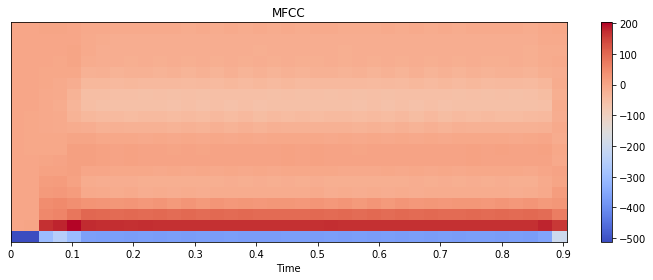

In [6]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mfcc[140,...], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [7]:
X_test_mfcc = np.reshape(X_test_mfcc, (X_test_mfcc.shape[0],-1))
X_train_mfcc = np.reshape(X_train_mfcc, (X_train_mfcc.shape[0],-1))
print X_test_mfcc.shape
print X_train_mfcc.shape

(200, 780)
(800, 780)


## Predictions

In [8]:
import sys
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.model_selection import GridSearchCV

headers=['algo', 'type', 'param1','param2','regularization',
         'target','metric', 'train_score', 'test_score']
with open(RESULTS_FILE, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(headers)

def evaluate_algo(algo_label, grid_reg, grid_class):
    results = []
    for t_i, t_name in enumerate(list(Y_train)):
        print 'predicting feature', t_name
        y_train = Y_train[[t_name]].values.flatten()
        y_test = Y_test[[t_name]].values.flatten()
        print y_train.dtype
        
        best_params_C = None
        best_params_R = None
        
        try:
            # Case 1: classification
            if y_train.dtype == 'object':

                metric = 'class'

                # Cross-Validation Score
                grid_class.fit(X_train_mfcc, y_train)
                cross_val_scores = grid_class.best_score_
                best_params_C = grid_class.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_class.predict(X_test_mfcc)
                test_score = accuracy_score(test_pred, y_test)
                print test_score


            # Case 2: regression
            elif y_train.dtype == 'float64':

                metric = 'reg'

                # Cross-Validation Score
                grid_reg.fit(X_train_mfcc, y_train)
                cross_val_scores = grid_reg.best_score_ * -1
                best_params_R = grid_reg.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_reg.predict(X_test_mfcc)
                test_score = mean_absolute_error(test_pred, y_test)
                print test_score

            else:
                raise ValueError('Wrong Column Type')

            out = (algo_label, 'per_output', best_params_R, best_params_C,None,
                   t_name, metric, cross_val_scores, test_score)
            print out
            with open(RESULTS_FILE, 'a') as f:
                writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
                writer.writerow(out)

        except:
            print "Unexpected error:", sys.exc_info()[0]

In [ ]:
from sklearn import neighbors

algo_C =neighbors.KNeighborsClassifier()
grid_C = GridSearchCV(algo_C, {"n_neighbors":[3,5,8,16]}, scoring='accuracy', verbose=2)

algo_R =neighbors.KNeighborsRegressor()
grid_R = GridSearchCV(algo_R, {"n_neighbors":[3,5,8,16]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('kNN', grid_R, grid_C)

In [ ]:
from sklearn import tree

algo_C = tree.DecisionTreeClassifier()
grid_C = GridSearchCV(algo_C, {"max_depth":[2,4,8,16,32,64,128]}, scoring='accuracy', verbose=2)

algo_R = tree.DecisionTreeRegressor()
grid_R = GridSearchCV(algo_R, {"max_depth":[2,4,8,16,32,64,128]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Decision Tree', grid_R, grid_C)

In [ ]:
from sklearn import dummy

algo_C = dummy.DummyClassifier()
grid_C = GridSearchCV(algo_C, {"strategy":["most_frequent"]}, scoring='accuracy', verbose=2)

algo_R = dummy.DummyRegressor()
grid_R = GridSearchCV(algo_R, {"strategy":["mean"]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Naive', grid_R, grid_C)

In [ ]:
# from sklearn import svm

# algo_R = svm.SVR(kernel='linear')
# grid_R = GridSearchCV(algo_R, {'C':[.01, .1, 1.]},
#                       scoring='neg_mean_absolute_error', verbose=2,
#                      n_jobs =4)

# algo_C = svm.SVC(kernel='linear')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1.]},
#                       scoring='accuracy', verbose=2,
#                       n_jobs =4)


# evaluate_algo('SVM_lin', grid_R, grid_C)

# algo_R = svm.SVR(kernel='RBF')
# grid_R = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='neg_mean_absolute_error', verbose=2)

# algo_C = svm.SVC(kernel='RBF')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='accuracy', verbose=2)


# evaluate_algo('SVM_RBF', grid_R, grid_C)

# Joint modelling + mid-level features

In [9]:
import collections

def target_info(df_y):
    infos = collections.OrderedDict()
    
    for i,name in enumerate(list(df_y)):
        print name
        
        y = df_y[[name]].values.flatten()
        infos[name] = {'type':y.dtype}
        
        if y.dtype=='object':
            u_vals = sorted(np.unique(y))
            infos[name]['int2char'] = {i:v for i,v in enumerate(u_vals)}
            infos[name]['char2int'] = {v:i for i,v in enumerate(u_vals)}
            
        elif y.dtype=='float64':
            infos[name]['mean'] = np.mean(y)
            infos[name]['sd'] = np.std(y)
        
    return infos

# Gets target info
Y_info = target_info(Y_train)
print Y_info

lfo1_rate
filter_cutoff
lfo1_amount
osc2_wave
filter_resonance
OrderedDict([('lfo1_rate', {'sd': 2.8756837733162297, 'type': dtype('float64'), 'mean': 5.064960629921563}), ('filter_cutoff', {'sd': 2.89234557524474, 'type': dtype('float64'), 'mean': 5.0103346456694338}), ('lfo1_amount', {'sd': 2.932316237542842, 'type': dtype('float64'), 'mean': 4.9543307086615656}), ('osc2_wave', {'char2int': {'Sine': 3, 'Noise': 0, 'Saw': 2, 'Triangle': 4, 'Pulse': 1}, 'int2char': {0: 'Noise', 1: 'Pulse', 2: 'Saw', 3: 'Sine', 4: 'Triangle'}, 'type': dtype('O')}), ('filter_resonance', {'sd': 2.9479893137687894, 'type': dtype('float64'), 'mean': 5.0626968503939489})])


In [10]:
L_test_mel = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mel = lr.feature.melspectrogram(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mels=N_MEL)
    L_test_mel.append(mel)
X_test_mel = np.stack(L_test_mel)
print X_test_mel.shape

L_train_mel = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mel = lr.feature.melspectrogram(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mels=N_MEL)
    L_train_mel.append(mel)
X_train_mel = np.stack(L_train_mel)
print X_train_mel.shape

(200, 32, 39)
(800, 32, 39)


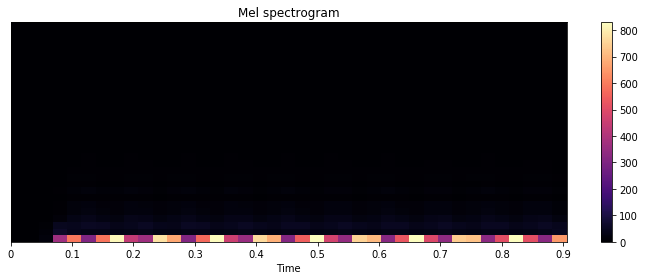

In [11]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mel[1,...], x_axis='time')
plt.colorbar()
plt.title('Mel spectrogram')
plt.tight_layout()

In [12]:
X_train_mel = np.transpose(X_train_mel, (0,2,1))
X_test_mel = np.transpose(X_test_mel, (0,2,1))
print X_train_mel.shape, X_test_mel.shape

(800, 39, 32) (200, 39, 32)


In [13]:
from keras.callbacks import EarlyStopping

def format_output(Y):
    out = {}
    for name,infos in Y_info.iteritems():
        if infos['type'] == 'float64':
            y = (Y[name] - infos['mean']) / infos['sd']
            
        elif infos['type'] == 'object':
            char2int = infos['char2int']
            y = np.zeros((len(Y[name]), len(char2int)))
            for i,yval in enumerate(Y[name]):
                y[i, char2int[yval]] = 1
                
        else:
            raise ValueError
        
        print name, y.shape
        out[name] = y
    
    return out

        
def test_model(label, params1, params2, regul, model):
    
    # Prepares input and output data
    X_mean = np.mean(X_train_mel, axis=(0))
    X_sd = np.std(X_train_mel, axis=(0))
    
    X_train = (X_train_mel - X_mean) / X_sd
    X_test  = (X_test_mel - X_mean) / X_sd
    
    Y_dict_train = format_output(Y_train)
    Y_dict_test  = format_output(Y_test)
    
    # Trains the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=25)
    hist = model.fit(X_train, Y_dict_train, 
              epochs=N_EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE,
             validation_split = VALIDATION, callbacks=[early_stopping])
    
    # Makes predictions
    pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
    
    # Gets validation and test scores (for each metric)
    Y = {}
    for j, Y_pred in enumerate(pred):
        t_name = Y_info.keys()[j]
        t_infos = Y_info[t_name]
        
        print t_name
        print Y_pred.shape

        if t_infos['type'] == 'float64':
            test_metric = 'reg'
            Y_pred = Y_pred.flatten()
            y_pred = Y_pred * t_infos['sd'] + t_infos['mean']
            y_pred = y_pred.tolist()
            test_score = mean_absolute_error(y_pred, Y_test[t_name])
        
        elif t_infos['type'] == 'object':
            test_metric = 'class'
            y_i = np.argmax(Y_pred, axis=1)
            y_pred = [t_infos['int2char'][y] for y in y_i]
            test_score = accuracy_score(y_pred, Y_test[t_name])

        else:
            raise ValueError
        
        #train_scores = hist.history[t_name + '_loss'][-1]
        train_scores = -1 * hist.history['val_loss'][-1]
        out = (label, 'joint', params1, params2, regul,
               t_name, test_metric, train_scores, test_score)
        print out
        with open(RESULTS_FILE, 'a') as f:
            writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
            writer.writerow(out)

        Y[t_name] = y_pred
    
    Y = pd.DataFrame(Y)
    return Y

Using TensorFlow backend.


In [14]:
# Model 1: 1 layer perceptron
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras import regularizers

def MLP(n_hidden_units, n_layers, regul):
    # Input layer
    in_shape = (X_test_mel.shape[1],X_test_mel.shape[2])
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = Flatten()(in_layer)
    for i in range(n_layers):
        h_layer = Dense(n_hidden_units, activation='relu')(h_layer)

    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name, 
                              kernel_regularizer=regularizers.l2(regul))(h_layer)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, kernel_regularizer=regularizers.l2(regul),
                              activation='softmax', name=name)(h_layer)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [16,32,64]:
        for REGUL in [0,0.01,0.1]:
            model = MLP(N_UNITS, N_LAYERS, REGUL)
            out = test_model('MLP', N_UNITS, N_LAYERS, REGUL, model)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 39, 32)        0                                            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 1248)          0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 16)            19984                                        
____________________________________________________________________________________________________
lfo1_rate (Dense)                (None, 1)             17                                           
___________________________________________________________________________________________

720/720 [==============================] - 0s - loss: 3.0978 - lfo1_rate_loss: 0.7640 - filter_cutoff_loss: 0.5260 - lfo1_amount_loss: 0.7434 - osc2_wave_loss: 0.4217 - filter_resonance_loss: 0.6426 - val_loss: 3.7164 - val_lfo1_rate_loss: 0.9693 - val_filter_cutoff_loss: 0.5923 - val_lfo1_amount_loss: 0.8133 - val_osc2_wave_loss: 0.5268 - val_filter_resonance_loss: 0.8147
Epoch 17/250
720/720 [==============================] - 0s - loss: 3.0093 - lfo1_rate_loss: 0.7426 - filter_cutoff_loss: 0.5373 - lfo1_amount_loss: 0.7237 - osc2_wave_loss: 0.3992 - filter_resonance_loss: 0.6065 - val_loss: 3.6945 - val_lfo1_rate_loss: 1.0167 - val_filter_cutoff_loss: 0.6070 - val_lfo1_amount_loss: 0.7941 - val_osc2_wave_loss: 0.5119 - val_filter_resonance_loss: 0.7648
Epoch 18/250
720/720 [==============================] - 0s - loss: 3.0095 - lfo1_rate_loss: 0.7429 - filter_cutoff_loss: 0.5072 - lfo1_amount_loss: 0.7344 - osc2_wave_loss: 0.3965 - filter_resonance_loss: 0.6285 - val_loss: 3.6157 - va

720/720 [==============================] - 0s - loss: 2.6122 - lfo1_rate_loss: 0.7030 - filter_cutoff_loss: 0.4552 - lfo1_amount_loss: 0.6596 - osc2_wave_loss: 0.2565 - filter_resonance_loss: 0.5379 - val_loss: 3.5446 - val_lfo1_rate_loss: 0.9674 - val_filter_cutoff_loss: 0.6330 - val_lfo1_amount_loss: 0.7965 - val_osc2_wave_loss: 0.3807 - val_filter_resonance_loss: 0.7670
Epoch 38/250
720/720 [==============================] - 0s - loss: 2.6112 - lfo1_rate_loss: 0.7041 - filter_cutoff_loss: 0.4572 - lfo1_amount_loss: 0.6510 - osc2_wave_loss: 0.2424 - filter_resonance_loss: 0.5565 - val_loss: 3.4950 - val_lfo1_rate_loss: 0.9779 - val_filter_cutoff_loss: 0.6609 - val_lfo1_amount_loss: 0.7691 - val_osc2_wave_loss: 0.3420 - val_filter_resonance_loss: 0.7451
Epoch 39/250
720/720 [==============================] - 0s - loss: 2.5883 - lfo1_rate_loss: 0.7001 - filter_cutoff_loss: 0.4441 - lfo1_amount_loss: 0.6518 - osc2_wave_loss: 0.2489 - filter_resonance_loss: 0.5434 - val_loss: 3.4997 - va

720/720 [==============================] - 0s - loss: 3.5480 - lfo1_rate_loss: 0.7761 - filter_cutoff_loss: 0.5744 - lfo1_amount_loss: 0.7704 - osc2_wave_loss: 0.6263 - filter_resonance_loss: 0.6821 - val_loss: 4.0456 - val_lfo1_rate_loss: 0.9712 - val_filter_cutoff_loss: 0.6646 - val_lfo1_amount_loss: 0.8300 - val_osc2_wave_loss: 0.6796 - val_filter_resonance_loss: 0.7814
Epoch 11/250
720/720 [==============================] - 0s - loss: 3.4810 - lfo1_rate_loss: 0.7719 - filter_cutoff_loss: 0.5654 - lfo1_amount_loss: 0.7766 - osc2_wave_loss: 0.5892 - filter_resonance_loss: 0.6589 - val_loss: 4.0246 - val_lfo1_rate_loss: 1.0227 - val_filter_cutoff_loss: 0.6336 - val_lfo1_amount_loss: 0.8160 - val_osc2_wave_loss: 0.6688 - val_filter_resonance_loss: 0.7644
Epoch 12/250
720/720 [==============================] - 0s - loss: 3.4215 - lfo1_rate_loss: 0.7494 - filter_cutoff_loss: 0.5605 - lfo1_amount_loss: 0.7541 - osc2_wave_loss: 0.5776 - filter_resonance_loss: 0.6608 - val_loss: 3.9722 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 0s - loss: 7.6012 - lfo1_rate_loss: 1.1382 - filter_cutoff_loss: 1.0446 - lfo1_amount_loss: 1.1432 - osc2_wave_loss: 1.6397 - filter_resonance_loss: 1.0905 - val_loss: 6.1791 - val_lfo1_rate_loss: 0.8426 - val_filter_cutoff_loss: 0.7321 - val_lfo1_amount_loss: 0.8885 - val_osc2_wave_loss: 1.2821 - val_filter_resonance_loss: 0.9484
Epoch 2/250
720/720 [==============================] - 0s - loss: 6.3886 - lfo1_rate_loss: 0.9963 - filter_cutoff_loss: 0.8343 - lfo1_amount_loss: 0.9642 - osc2_wave_loss: 1.2593 - filter_resonance_loss: 0.8947 - val_loss: 5.9526 - val_lfo1_rate_loss: 0.9508 - val_filter_cutoff_loss: 0.7593 - val_lfo1_amount_loss: 0.8428 - val_osc2_wave_loss: 1.1040 - val_filter_resonance_loss: 0.9039
Epoch 3/250
720/720 [==============================] - 0s - loss: 5.9008 - lfo1_rate_loss: 0.9314 - filter_cutoff_loss: 0.7515 - lfo1_amount_loss: 0.9167 - osc2_wave_loss: 1.1129 

720/720 [==============================] - 0s - loss: 3.5670 - lfo1_rate_loss: 0.6825 - filter_cutoff_loss: 0.4820 - lfo1_amount_loss: 0.6837 - osc2_wave_loss: 0.4971 - filter_resonance_loss: 0.5937 - val_loss: 4.3101 - val_lfo1_rate_loss: 0.9535 - val_filter_cutoff_loss: 0.6488 - val_lfo1_amount_loss: 0.8631 - val_osc2_wave_loss: 0.5444 - val_filter_resonance_loss: 0.6818
Epoch 22/250
720/720 [==============================] - 0s - loss: 3.5092 - lfo1_rate_loss: 0.6847 - filter_cutoff_loss: 0.4764 - lfo1_amount_loss: 0.6771 - osc2_wave_loss: 0.4918 - filter_resonance_loss: 0.5690 - val_loss: 4.3636 - val_lfo1_rate_loss: 1.0271 - val_filter_cutoff_loss: 0.6391 - val_lfo1_amount_loss: 0.8482 - val_osc2_wave_loss: 0.5341 - val_filter_resonance_loss: 0.7141
Epoch 23/250
720/720 [==============================] - 0s - loss: 3.5024 - lfo1_rate_loss: 0.7037 - filter_cutoff_loss: 0.4732 - lfo1_amount_loss: 0.6721 - osc2_wave_loss: 0.4837 - filter_resonance_loss: 0.5769 - val_loss: 4.2963 - va

720/720 [==============================] - 0s - loss: 3.0120 - lfo1_rate_loss: 0.6413 - filter_cutoff_loss: 0.4314 - lfo1_amount_loss: 0.6147 - osc2_wave_loss: 0.3813 - filter_resonance_loss: 0.5382 - val_loss: 3.9242 - val_lfo1_rate_loss: 0.9635 - val_filter_cutoff_loss: 0.6272 - val_lfo1_amount_loss: 0.8203 - val_osc2_wave_loss: 0.4327 - val_filter_resonance_loss: 0.6784
Epoch 43/250
720/720 [==============================] - 0s - loss: 2.9711 - lfo1_rate_loss: 0.6308 - filter_cutoff_loss: 0.4288 - lfo1_amount_loss: 0.6202 - osc2_wave_loss: 0.3761 - filter_resonance_loss: 0.5152 - val_loss: 3.8804 - val_lfo1_rate_loss: 0.9553 - val_filter_cutoff_loss: 0.6155 - val_lfo1_amount_loss: 0.8196 - val_osc2_wave_loss: 0.4245 - val_filter_resonance_loss: 0.6683
Epoch 44/250
720/720 [==============================] - 0s - loss: 2.9761 - lfo1_rate_loss: 0.6372 - filter_cutoff_loss: 0.4302 - lfo1_amount_loss: 0.6177 - osc2_wave_loss: 0.3785 - filter_resonance_loss: 0.5182 - val_loss: 3.8868 - va

720/720 [==============================] - 0s - loss: 2.7305 - lfo1_rate_loss: 0.6125 - filter_cutoff_loss: 0.4004 - lfo1_amount_loss: 0.5900 - osc2_wave_loss: 0.3165 - filter_resonance_loss: 0.4874 - val_loss: 3.7750 - val_lfo1_rate_loss: 0.9568 - val_filter_cutoff_loss: 0.6037 - val_lfo1_amount_loss: 0.8403 - val_osc2_wave_loss: 0.3813 - val_filter_resonance_loss: 0.6707
Epoch 64/250
720/720 [==============================] - 0s - loss: 2.7598 - lfo1_rate_loss: 0.6152 - filter_cutoff_loss: 0.4095 - lfo1_amount_loss: 0.5992 - osc2_wave_loss: 0.3139 - filter_resonance_loss: 0.5008 - val_loss: 3.7922 - val_lfo1_rate_loss: 0.9557 - val_filter_cutoff_loss: 0.6194 - val_lfo1_amount_loss: 0.8595 - val_osc2_wave_loss: 0.3794 - val_filter_resonance_loss: 0.6585
Epoch 65/250
720/720 [==============================] - 0s - loss: 2.7381 - lfo1_rate_loss: 0.6177 - filter_cutoff_loss: 0.4025 - lfo1_amount_loss: 0.5999 - osc2_wave_loss: 0.3121 - filter_resonance_loss: 0.4878 - val_loss: 3.8348 - va

720/720 [==============================] - 0s - loss: 2.5729 - lfo1_rate_loss: 0.5971 - filter_cutoff_loss: 0.3628 - lfo1_amount_loss: 0.5734 - osc2_wave_loss: 0.2766 - filter_resonance_loss: 0.4830 - val_loss: 3.7956 - val_lfo1_rate_loss: 0.9776 - val_filter_cutoff_loss: 0.6455 - val_lfo1_amount_loss: 0.8450 - val_osc2_wave_loss: 0.3472 - val_filter_resonance_loss: 0.7012
Epoch 85/250
720/720 [==============================] - 0s - loss: 2.5611 - lfo1_rate_loss: 0.6024 - filter_cutoff_loss: 0.3750 - lfo1_amount_loss: 0.5636 - osc2_wave_loss: 0.2736 - filter_resonance_loss: 0.4682 - val_loss: 3.7110 - val_lfo1_rate_loss: 0.9790 - val_filter_cutoff_loss: 0.6063 - val_lfo1_amount_loss: 0.8282 - val_osc2_wave_loss: 0.3459 - val_filter_resonance_loss: 0.6742
Epoch 86/250
720/720 [==============================] - 0s - loss: 2.5628 - lfo1_rate_loss: 0.6002 - filter_cutoff_loss: 0.3737 - lfo1_amount_loss: 0.5704 - osc2_wave_loss: 0.2733 - filter_resonance_loss: 0.4689 - val_loss: 3.7202 - va

720/720 [==============================] - 0s - loss: 3.1681 - lfo1_rate_loss: 0.7838 - filter_cutoff_loss: 0.5441 - lfo1_amount_loss: 0.7501 - osc2_wave_loss: 0.4324 - filter_resonance_loss: 0.6576 - val_loss: 3.5189 - val_lfo1_rate_loss: 0.8845 - val_filter_cutoff_loss: 0.6113 - val_lfo1_amount_loss: 0.8552 - val_osc2_wave_loss: 0.4531 - val_filter_resonance_loss: 0.7149
Epoch 10/250
720/720 [==============================] - 0s - loss: 3.0661 - lfo1_rate_loss: 0.7688 - filter_cutoff_loss: 0.5298 - lfo1_amount_loss: 0.7182 - osc2_wave_loss: 0.3939 - filter_resonance_loss: 0.6553 - val_loss: 3.4633 - val_lfo1_rate_loss: 0.8617 - val_filter_cutoff_loss: 0.6191 - val_lfo1_amount_loss: 0.8708 - val_osc2_wave_loss: 0.4194 - val_filter_resonance_loss: 0.6922
Epoch 11/250
720/720 [==============================] - 0s - loss: 3.0000 - lfo1_rate_loss: 0.7503 - filter_cutoff_loss: 0.5164 - lfo1_amount_loss: 0.7623 - osc2_wave_loss: 0.3770 - filter_resonance_loss: 0.5940 - val_loss: 3.5794 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 0s - loss: 5.9412 - lfo1_rate_loss: 1.0908 - filter_cutoff_loss: 1.0431 - lfo1_amount_loss: 1.1161 - osc2_wave_loss: 1.5367 - filter_resonance_loss: 0.9787 - val_loss: 4.8799 - val_lfo1_rate_loss: 1.0044 - val_filter_cutoff_loss: 0.8221 - val_lfo1_amount_loss: 0.9875 - val_osc2_wave_loss: 1.1046 - val_filter_resonance_loss: 0.7881
Epoch 2/250
720/720 [==============================] - 0s - loss: 4.7474 - lfo1_rate_loss: 0.9084 - filter_cutoff_loss: 0.8856 - lfo1_amount_loss: 0.9459 - osc2_wave_loss: 0.9881 - filter_resonance_loss: 0.8477 - val_loss: 4.5094 - val_lfo1_rate_loss: 0.9596 - val_filter_cutoff_loss: 0.8386 - val_lfo1_amount_loss: 0.8871 - val_osc2_wave_loss: 0.8439 - val_filter_resonance_loss: 0.8102
Epoch 3/250
720/720 [==============================] - 0s - loss: 4.1665 - lfo1_rate_loss: 0.8468 - filter_cutoff_loss: 0.7377 - lfo1_amount_loss: 0.8811 - osc2_wave_loss: 0.7680 

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 39, 32)        0                                            
____________________________________________________________________________________________________
flatten_6 (Flatten)              (None, 1248)          0                                            
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 32)            39968                                        
____________________________________________________________________________________________________
lfo1_rate (Dense)                (None, 1)             33                                           
___________________________________________________________________________________________

720/720 [==============================] - 0s - loss: 3.4286 - lfo1_rate_loss: 0.6766 - filter_cutoff_loss: 0.4861 - lfo1_amount_loss: 0.6933 - osc2_wave_loss: 0.3856 - filter_resonance_loss: 0.5842 - val_loss: 4.0574 - val_lfo1_rate_loss: 0.8369 - val_filter_cutoff_loss: 0.6529 - val_lfo1_amount_loss: 0.8158 - val_osc2_wave_loss: 0.4776 - val_filter_resonance_loss: 0.6852
Epoch 17/250
720/720 [==============================] - 0s - loss: 3.3055 - lfo1_rate_loss: 0.6796 - filter_cutoff_loss: 0.4610 - lfo1_amount_loss: 0.6735 - osc2_wave_loss: 0.3773 - filter_resonance_loss: 0.5357 - val_loss: 4.0538 - val_lfo1_rate_loss: 0.9018 - val_filter_cutoff_loss: 0.6179 - val_lfo1_amount_loss: 0.8162 - val_osc2_wave_loss: 0.4750 - val_filter_resonance_loss: 0.6763
Epoch 18/250
720/720 [==============================] - 0s - loss: 3.2351 - lfo1_rate_loss: 0.6549 - filter_cutoff_loss: 0.4462 - lfo1_amount_loss: 0.6586 - osc2_wave_loss: 0.3687 - filter_resonance_loss: 0.5503 - val_loss: 3.9823 - va

 32/200 [===>..........................] - ETA: 0slfo1_rate
(200, 1)
('MLP', 'joint', 32, 1, 0.1, 'lfo1_rate', 'reg', -3.6986530303955076, 2.8877924962872363)
filter_cutoff
(200, 1)
('MLP', 'joint', 32, 1, 0.1, 'filter_cutoff', 'reg', -3.6986530303955076, 1.7078067817652078)
lfo1_amount
(200, 1)
('MLP', 'joint', 32, 1, 0.1, 'lfo1_amount', 'reg', -3.6986530303955076, 2.959599996223111)
osc2_wave
(200, 5)
('MLP', 'joint', 32, 1, 0.1, 'osc2_wave', 'class', -3.6986530303955076, 0.88)
filter_resonance
(200, 1)
('MLP', 'joint', 32, 1, 0.1, 'filter_resonance', 'reg', -3.6986530303955076, 2.0459792933782981)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 39, 32)        0                                            
_________________________________________________________________________________________

720/720 [==============================] - 0s - loss: 2.8970 - lfo1_rate_loss: 0.7593 - filter_cutoff_loss: 0.5387 - lfo1_amount_loss: 0.7038 - osc2_wave_loss: 0.2463 - filter_resonance_loss: 0.6489 - val_loss: 3.4757 - val_lfo1_rate_loss: 0.8990 - val_filter_cutoff_loss: 0.6746 - val_lfo1_amount_loss: 0.8808 - val_osc2_wave_loss: 0.2847 - val_filter_resonance_loss: 0.7365
Epoch 15/250
720/720 [==============================] - 0s - loss: 2.8351 - lfo1_rate_loss: 0.7305 - filter_cutoff_loss: 0.5399 - lfo1_amount_loss: 0.7186 - osc2_wave_loss: 0.2337 - filter_resonance_loss: 0.6124 - val_loss: 3.4701 - val_lfo1_rate_loss: 0.9742 - val_filter_cutoff_loss: 0.6002 - val_lfo1_amount_loss: 0.8479 - val_osc2_wave_loss: 0.2722 - val_filter_resonance_loss: 0.7756
Epoch 16/250
720/720 [==============================] - 0s - loss: 2.7666 - lfo1_rate_loss: 0.7264 - filter_cutoff_loss: 0.4862 - lfo1_amount_loss: 0.6960 - osc2_wave_loss: 0.2247 - filter_resonance_loss: 0.6333 - val_loss: 3.4192 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 0s - loss: 5.6482 - lfo1_rate_loss: 1.1315 - filter_cutoff_loss: 0.9860 - lfo1_amount_loss: 1.1009 - osc2_wave_loss: 1.2602 - filter_resonance_loss: 1.0020 - val_loss: 4.6396 - val_lfo1_rate_loss: 1.0701 - val_filter_cutoff_loss: 0.7087 - val_lfo1_amount_loss: 0.9012 - val_osc2_wave_loss: 0.8833 - val_filter_resonance_loss: 0.9114
Epoch 2/250
720/720 [==============================] - 0s - loss: 4.5731 - lfo1_rate_loss: 0.9666 - filter_cutoff_loss: 0.8169 - lfo1_amount_loss: 0.9282 - osc2_wave_loss: 0.7258 - filter_resonance_loss: 0.9720 - val_loss: 4.1329 - val_lfo1_rate_loss: 0.9218 - val_filter_cutoff_loss: 0.7597 - val_lfo1_amount_loss: 0.8493 - val_osc2_wave_loss: 0.7048 - val_filter_resonance_loss: 0.7350
Epoch 3/250
720/720 [==============================] - 0s - loss: 4.1415 - lfo1_rate_loss: 0.9708 - filter_cutoff_loss: 0.7287 - lfo1_amount_loss: 0.9325 - osc2_wave_loss: 0.5660 

 32/200 [===>..........................] - ETA: 1slfo1_rate
(200, 1)
('MLP', 'joint', 64, 1, 0.01, 'lfo1_rate', 'reg', -3.5193061828613281, 2.8979954107356609)
filter_cutoff
(200, 1)
('MLP', 'joint', 64, 1, 0.01, 'filter_cutoff', 'reg', -3.5193061828613281, 2.1513870838028195)
lfo1_amount
(200, 1)
('MLP', 'joint', 64, 1, 0.01, 'lfo1_amount', 'reg', -3.5193061828613281, 2.8933834628982926)
osc2_wave
(200, 5)
('MLP', 'joint', 64, 1, 0.01, 'osc2_wave', 'class', -3.5193061828613281, 0.89000000000000001)
filter_resonance
(200, 1)
('MLP', 'joint', 64, 1, 0.01, 'filter_resonance', 'reg', -3.5193061828613281, 2.3364452191413818)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 39, 32)        0                                            
____________________________________________________________________

720/720 [==============================] - 0s - loss: 3.5937 - lfo1_rate_loss: 0.7259 - filter_cutoff_loss: 0.5384 - lfo1_amount_loss: 0.7207 - osc2_wave_loss: 0.3379 - filter_resonance_loss: 0.5912 - val_loss: 4.3696 - val_lfo1_rate_loss: 1.0117 - val_filter_cutoff_loss: 0.6987 - val_lfo1_amount_loss: 0.8704 - val_osc2_wave_loss: 0.4553 - val_filter_resonance_loss: 0.6754
Epoch 14/250
720/720 [==============================] - 0s - loss: 3.4624 - lfo1_rate_loss: 0.7300 - filter_cutoff_loss: 0.5014 - lfo1_amount_loss: 0.6698 - osc2_wave_loss: 0.3397 - filter_resonance_loss: 0.5794 - val_loss: 4.1687 - val_lfo1_rate_loss: 0.9505 - val_filter_cutoff_loss: 0.6630 - val_lfo1_amount_loss: 0.8424 - val_osc2_wave_loss: 0.4405 - val_filter_resonance_loss: 0.6482
Epoch 15/250
720/720 [==============================] - 0s - loss: 3.3604 - lfo1_rate_loss: 0.7168 - filter_cutoff_loss: 0.5115 - lfo1_amount_loss: 0.6380 - osc2_wave_loss: 0.3268 - filter_resonance_loss: 0.5580 - val_loss: 4.1489 - va

720/720 [==============================] - 0s - loss: 2.6638 - lfo1_rate_loss: 0.6174 - filter_cutoff_loss: 0.3957 - lfo1_amount_loss: 0.5797 - osc2_wave_loss: 0.2281 - filter_resonance_loss: 0.5014 - val_loss: 3.6959 - val_lfo1_rate_loss: 0.9428 - val_filter_cutoff_loss: 0.6201 - val_lfo1_amount_loss: 0.8361 - val_osc2_wave_loss: 0.3265 - val_filter_resonance_loss: 0.6322
Epoch 35/250
720/720 [==============================] - 0s - loss: 2.6179 - lfo1_rate_loss: 0.6288 - filter_cutoff_loss: 0.3874 - lfo1_amount_loss: 0.5639 - osc2_wave_loss: 0.2244 - filter_resonance_loss: 0.4785 - val_loss: 3.7076 - val_lfo1_rate_loss: 0.9111 - val_filter_cutoff_loss: 0.6427 - val_lfo1_amount_loss: 0.8442 - val_osc2_wave_loss: 0.3277 - val_filter_resonance_loss: 0.6499
Epoch 36/250
720/720 [==============================] - 0s - loss: 2.6167 - lfo1_rate_loss: 0.6139 - filter_cutoff_loss: 0.3828 - lfo1_amount_loss: 0.5731 - osc2_wave_loss: 0.2202 - filter_resonance_loss: 0.4973 - val_loss: 3.6481 - va

720/720 [==============================] - 0s - loss: 2.3416 - lfo1_rate_loss: 0.5779 - filter_cutoff_loss: 0.3394 - lfo1_amount_loss: 0.5450 - osc2_wave_loss: 0.1780 - filter_resonance_loss: 0.4423 - val_loss: 3.4833 - val_lfo1_rate_loss: 0.9323 - val_filter_cutoff_loss: 0.5809 - val_lfo1_amount_loss: 0.8366 - val_osc2_wave_loss: 0.2812 - val_filter_resonance_loss: 0.5946
Epoch 56/250
720/720 [==============================] - 0s - loss: 2.3366 - lfo1_rate_loss: 0.5811 - filter_cutoff_loss: 0.3537 - lfo1_amount_loss: 0.5313 - osc2_wave_loss: 0.1751 - filter_resonance_loss: 0.4392 - val_loss: 3.4957 - val_lfo1_rate_loss: 0.9312 - val_filter_cutoff_loss: 0.6031 - val_lfo1_amount_loss: 0.8172 - val_osc2_wave_loss: 0.2728 - val_filter_resonance_loss: 0.6164
Epoch 57/250
720/720 [==============================] - 0s - loss: 2.3229 - lfo1_rate_loss: 0.5796 - filter_cutoff_loss: 0.3462 - lfo1_amount_loss: 0.5232 - osc2_wave_loss: 0.1744 - filter_resonance_loss: 0.4451 - val_loss: 3.4282 - va

720/720 [==============================] - 0s - loss: 3.7786 - lfo1_rate_loss: 0.7672 - filter_cutoff_loss: 0.6048 - lfo1_amount_loss: 0.7868 - osc2_wave_loss: 0.8747 - filter_resonance_loss: 0.7451 - val_loss: 4.1001 - val_lfo1_rate_loss: 0.8266 - val_filter_cutoff_loss: 0.6536 - val_lfo1_amount_loss: 0.8233 - val_osc2_wave_loss: 1.0020 - val_filter_resonance_loss: 0.7947
Epoch 9/250
720/720 [==============================] - 0s - loss: 3.6195 - lfo1_rate_loss: 0.7574 - filter_cutoff_loss: 0.5529 - lfo1_amount_loss: 0.7788 - osc2_wave_loss: 0.7921 - filter_resonance_loss: 0.7383 - val_loss: 3.9836 - val_lfo1_rate_loss: 0.8270 - val_filter_cutoff_loss: 0.6330 - val_lfo1_amount_loss: 0.8218 - val_osc2_wave_loss: 0.9152 - val_filter_resonance_loss: 0.7867
Epoch 10/250
720/720 [==============================] - 0s - loss: 3.5369 - lfo1_rate_loss: 0.7718 - filter_cutoff_loss: 0.5584 - lfo1_amount_loss: 0.7785 - osc2_wave_loss: 0.7045 - filter_resonance_loss: 0.7238 - val_loss: 4.0589 - val

720/720 [==============================] - 0s - loss: 2.7588 - lfo1_rate_loss: 0.6998 - filter_cutoff_loss: 0.4528 - lfo1_amount_loss: 0.7053 - osc2_wave_loss: 0.2746 - filter_resonance_loss: 0.6262 - val_loss: 3.3664 - val_lfo1_rate_loss: 0.8807 - val_filter_cutoff_loss: 0.6141 - val_lfo1_amount_loss: 0.8249 - val_osc2_wave_loss: 0.2998 - val_filter_resonance_loss: 0.7469
Epoch 30/250
720/720 [==============================] - 0s - loss: 2.7127 - lfo1_rate_loss: 0.6870 - filter_cutoff_loss: 0.4435 - lfo1_amount_loss: 0.7097 - osc2_wave_loss: 0.2642 - filter_resonance_loss: 0.6083 - val_loss: 3.3622 - val_lfo1_rate_loss: 0.8911 - val_filter_cutoff_loss: 0.6023 - val_lfo1_amount_loss: 0.8370 - val_osc2_wave_loss: 0.2957 - val_filter_resonance_loss: 0.7362
Epoch 31/250
720/720 [==============================] - 0s - loss: 2.6839 - lfo1_rate_loss: 0.6796 - filter_cutoff_loss: 0.4509 - lfo1_amount_loss: 0.6960 - osc2_wave_loss: 0.2520 - filter_resonance_loss: 0.6053 - val_loss: 3.3872 - va

720/720 [==============================] - 0s - loss: 4.5006 - lfo1_rate_loss: 0.8623 - filter_cutoff_loss: 0.7179 - lfo1_amount_loss: 0.8717 - osc2_wave_loss: 1.0919 - filter_resonance_loss: 0.8095 - val_loss: 4.4112 - val_lfo1_rate_loss: 0.9051 - val_filter_cutoff_loss: 0.6098 - val_lfo1_amount_loss: 0.8715 - val_osc2_wave_loss: 1.0685 - val_filter_resonance_loss: 0.8099
Epoch 4/250
720/720 [==============================] - 0s - loss: 4.2545 - lfo1_rate_loss: 0.8519 - filter_cutoff_loss: 0.6834 - lfo1_amount_loss: 0.8537 - osc2_wave_loss: 0.9765 - filter_resonance_loss: 0.7431 - val_loss: 4.3462 - val_lfo1_rate_loss: 0.9071 - val_filter_cutoff_loss: 0.6173 - val_lfo1_amount_loss: 0.8870 - val_osc2_wave_loss: 0.9665 - val_filter_resonance_loss: 0.8228
Epoch 5/250
720/720 [==============================] - 0s - loss: 4.0707 - lfo1_rate_loss: 0.8354 - filter_cutoff_loss: 0.6329 - lfo1_amount_loss: 0.8529 - osc2_wave_loss: 0.8818 - filter_resonance_loss: 0.7227 - val_loss: 4.1909 - val_

720/720 [==============================] - 0s - loss: 3.0225 - lfo1_rate_loss: 0.7020 - filter_cutoff_loss: 0.4994 - lfo1_amount_loss: 0.7782 - osc2_wave_loss: 0.3233 - filter_resonance_loss: 0.5807 - val_loss: 3.6933 - val_lfo1_rate_loss: 0.8957 - val_filter_cutoff_loss: 0.5780 - val_lfo1_amount_loss: 0.8988 - val_osc2_wave_loss: 0.4716 - val_filter_resonance_loss: 0.7104
Epoch 25/250
720/720 [==============================] - 0s - loss: 2.9885 - lfo1_rate_loss: 0.6996 - filter_cutoff_loss: 0.4978 - lfo1_amount_loss: 0.7780 - osc2_wave_loss: 0.3169 - filter_resonance_loss: 0.5577 - val_loss: 3.7597 - val_lfo1_rate_loss: 0.9520 - val_filter_cutoff_loss: 0.6063 - val_lfo1_amount_loss: 0.8939 - val_osc2_wave_loss: 0.4729 - val_filter_resonance_loss: 0.6962
Epoch 26/250
720/720 [==============================] - 0s - loss: 2.9434 - lfo1_rate_loss: 0.6911 - filter_cutoff_loss: 0.4737 - lfo1_amount_loss: 0.7681 - osc2_wave_loss: 0.3083 - filter_resonance_loss: 0.5639 - val_loss: 3.7678 - va

720/720 [==============================] - 0s - loss: 4.6807 - lfo1_rate_loss: 0.7615 - filter_cutoff_loss: 0.5740 - lfo1_amount_loss: 0.8034 - osc2_wave_loss: 0.9888 - filter_resonance_loss: 0.7050 - val_loss: 4.8258 - val_lfo1_rate_loss: 0.8863 - val_filter_cutoff_loss: 0.5265 - val_lfo1_amount_loss: 0.8645 - val_osc2_wave_loss: 0.9448 - val_filter_resonance_loss: 0.7793
Epoch 10/250
720/720 [==============================] - 0s - loss: 4.5320 - lfo1_rate_loss: 0.7508 - filter_cutoff_loss: 0.5465 - lfo1_amount_loss: 0.7830 - osc2_wave_loss: 0.9574 - filter_resonance_loss: 0.6895 - val_loss: 4.7299 - val_lfo1_rate_loss: 0.8979 - val_filter_cutoff_loss: 0.5243 - val_lfo1_amount_loss: 0.8877 - val_osc2_wave_loss: 0.8890 - val_filter_resonance_loss: 0.7476
Epoch 11/250
720/720 [==============================] - 0s - loss: 4.4055 - lfo1_rate_loss: 0.7427 - filter_cutoff_loss: 0.5383 - lfo1_amount_loss: 0.7838 - osc2_wave_loss: 0.9079 - filter_resonance_loss: 0.6669 - val_loss: 4.7134 - va

720/720 [==============================] - 0s - loss: 3.2745 - lfo1_rate_loss: 0.6786 - filter_cutoff_loss: 0.4414 - lfo1_amount_loss: 0.6952 - osc2_wave_loss: 0.4765 - filter_resonance_loss: 0.5438 - val_loss: 3.9701 - val_lfo1_rate_loss: 0.8838 - val_filter_cutoff_loss: 0.5978 - val_lfo1_amount_loss: 0.8531 - val_osc2_wave_loss: 0.5335 - val_filter_resonance_loss: 0.6676
Epoch 31/250
720/720 [==============================] - 0s - loss: 3.2630 - lfo1_rate_loss: 0.6778 - filter_cutoff_loss: 0.4484 - lfo1_amount_loss: 0.6863 - osc2_wave_loss: 0.4655 - filter_resonance_loss: 0.5546 - val_loss: 3.9401 - val_lfo1_rate_loss: 0.8990 - val_filter_cutoff_loss: 0.5711 - val_lfo1_amount_loss: 0.8441 - val_osc2_wave_loss: 0.5344 - val_filter_resonance_loss: 0.6655
Epoch 32/250
720/720 [==============================] - 0s - loss: 3.2043 - lfo1_rate_loss: 0.6789 - filter_cutoff_loss: 0.4326 - lfo1_amount_loss: 0.6830 - osc2_wave_loss: 0.4531 - filter_resonance_loss: 0.5341 - val_loss: 3.8446 - va

720/720 [==============================] - 0s - loss: 2.8425 - lfo1_rate_loss: 0.6382 - filter_cutoff_loss: 0.4051 - lfo1_amount_loss: 0.6488 - osc2_wave_loss: 0.3307 - filter_resonance_loss: 0.4893 - val_loss: 3.6242 - val_lfo1_rate_loss: 0.8818 - val_filter_cutoff_loss: 0.5312 - val_lfo1_amount_loss: 0.8126 - val_osc2_wave_loss: 0.4319 - val_filter_resonance_loss: 0.6384
Epoch 52/250
720/720 [==============================] - 0s - loss: 2.8195 - lfo1_rate_loss: 0.6417 - filter_cutoff_loss: 0.3946 - lfo1_amount_loss: 0.6369 - osc2_wave_loss: 0.3325 - filter_resonance_loss: 0.4868 - val_loss: 3.6353 - val_lfo1_rate_loss: 0.8479 - val_filter_cutoff_loss: 0.5613 - val_lfo1_amount_loss: 0.8342 - val_osc2_wave_loss: 0.4212 - val_filter_resonance_loss: 0.6455
Epoch 53/250
 32/200 [===>..........................] - ETA: 1slfo1_rate
(200, 1)
('MLP', 'joint', 16, 2, 0.1, 'lfo1_rate', 'reg', -3.6218170166015624, 2.9158092716081647)
filter_cutoff
(200, 1)
('MLP', 'joint', 16, 2, 0.1, 'filter_cut

720/720 [==============================] - 0s - loss: 3.0978 - lfo1_rate_loss: 0.7429 - filter_cutoff_loss: 0.5331 - lfo1_amount_loss: 0.7165 - osc2_wave_loss: 0.4740 - filter_resonance_loss: 0.6313 - val_loss: 3.5048 - val_lfo1_rate_loss: 0.8999 - val_filter_cutoff_loss: 0.5763 - val_lfo1_amount_loss: 0.7967 - val_osc2_wave_loss: 0.5692 - val_filter_resonance_loss: 0.6627
Epoch 11/250
720/720 [==============================] - 0s - loss: 2.9634 - lfo1_rate_loss: 0.7209 - filter_cutoff_loss: 0.5054 - lfo1_amount_loss: 0.7051 - osc2_wave_loss: 0.4231 - filter_resonance_loss: 0.6088 - val_loss: 3.4684 - val_lfo1_rate_loss: 0.9001 - val_filter_cutoff_loss: 0.5787 - val_lfo1_amount_loss: 0.7891 - val_osc2_wave_loss: 0.5392 - val_filter_resonance_loss: 0.6613
Epoch 12/250
720/720 [==============================] - 0s - loss: 2.9199 - lfo1_rate_loss: 0.7312 - filter_cutoff_loss: 0.4930 - lfo1_amount_loss: 0.6974 - osc2_wave_loss: 0.4058 - filter_resonance_loss: 0.5926 - val_loss: 3.4895 - va

Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 0s - loss: 5.3152 - lfo1_rate_loss: 0.9686 - filter_cutoff_loss: 0.8807 - lfo1_amount_loss: 0.9971 - osc2_wave_loss: 1.4026 - filter_resonance_loss: 0.9068 - val_loss: 4.6850 - val_lfo1_rate_loss: 0.9095 - val_filter_cutoff_loss: 0.7075 - val_lfo1_amount_loss: 0.8669 - val_osc2_wave_loss: 1.1983 - val_filter_resonance_loss: 0.8462
Epoch 2/250
720/720 [==============================] - 0s - loss: 4.4644 - lfo1_rate_loss: 0.8898 - filter_cutoff_loss: 0.7130 - lfo1_amount_loss: 0.8856 - osc2_wave_loss: 1.0265 - filter_resonance_loss: 0.7946 - val_loss: 4.3290 - val_lfo1_rate_loss: 0.8607 - val_filter_cutoff_loss: 0.6465 - val_lfo1_amount_loss: 0.8442 - val_osc2_wave_loss: 1.0015 - val_filter_resonance_loss: 0.8230
Epoch 3/250
720/720 [==============================] - 0s - loss: 4.0723 - lfo1_rate_loss: 0.8376 - filter_cutoff_loss: 0.6538 - lfo1_amount_loss: 0.8240 - osc2_wave_loss: 0.8471 

720/720 [==============================] - 0s - loss: 2.5973 - lfo1_rate_loss: 0.6547 - filter_cutoff_loss: 0.4477 - lfo1_amount_loss: 0.6291 - osc2_wave_loss: 0.2131 - filter_resonance_loss: 0.5123 - val_loss: 3.3710 - val_lfo1_rate_loss: 0.8660 - val_filter_cutoff_loss: 0.5544 - val_lfo1_amount_loss: 0.8256 - val_osc2_wave_loss: 0.3290 - val_filter_resonance_loss: 0.6561
Epoch 22/250
720/720 [==============================] - 0s - loss: 2.5582 - lfo1_rate_loss: 0.6425 - filter_cutoff_loss: 0.4369 - lfo1_amount_loss: 0.6180 - osc2_wave_loss: 0.2125 - filter_resonance_loss: 0.5085 - val_loss: 3.5389 - val_lfo1_rate_loss: 0.9466 - val_filter_cutoff_loss: 0.5690 - val_lfo1_amount_loss: 0.8411 - val_osc2_wave_loss: 0.3758 - val_filter_resonance_loss: 0.6668
Epoch 23/250
720/720 [==============================] - 0s - loss: 2.5400 - lfo1_rate_loss: 0.6451 - filter_cutoff_loss: 0.4178 - lfo1_amount_loss: 0.6350 - osc2_wave_loss: 0.1977 - filter_resonance_loss: 0.5051 - val_loss: 3.4058 - va

lfo1_amount (200,)
osc2_wave (200, 5)
filter_resonance (200,)
Train on 720 samples, validate on 80 samples
Epoch 1/250
720/720 [==============================] - 0s - loss: 6.6039 - lfo1_rate_loss: 0.9438 - filter_cutoff_loss: 0.8629 - lfo1_amount_loss: 0.9831 - osc2_wave_loss: 1.4819 - filter_resonance_loss: 0.8724 - val_loss: 5.8260 - val_lfo1_rate_loss: 0.8665 - val_filter_cutoff_loss: 0.6398 - val_lfo1_amount_loss: 0.9245 - val_osc2_wave_loss: 1.2609 - val_filter_resonance_loss: 0.7621
Epoch 2/250
720/720 [==============================] - 0s - loss: 5.8037 - lfo1_rate_loss: 0.8789 - filter_cutoff_loss: 0.7183 - lfo1_amount_loss: 0.8820 - osc2_wave_loss: 1.2027 - filter_resonance_loss: 0.8156 - val_loss: 5.4541 - val_lfo1_rate_loss: 0.8637 - val_filter_cutoff_loss: 0.6027 - val_lfo1_amount_loss: 0.8813 - val_osc2_wave_loss: 1.0929 - val_filter_resonance_loss: 0.7775
Epoch 3/250
720/720 [==============================] - 0s - loss: 5.3126 - lfo1_rate_loss: 0.8147 - filter_cutoff_los

720/720 [==============================] - 0s - loss: 3.0237 - lfo1_rate_loss: 0.6514 - filter_cutoff_loss: 0.4233 - lfo1_amount_loss: 0.6577 - osc2_wave_loss: 0.3490 - filter_resonance_loss: 0.5329 - val_loss: 3.6290 - val_lfo1_rate_loss: 0.9238 - val_filter_cutoff_loss: 0.5140 - val_lfo1_amount_loss: 0.7674 - val_osc2_wave_loss: 0.4154 - val_filter_resonance_loss: 0.6054
Epoch 22/250
720/720 [==============================] - 0s - loss: 2.9584 - lfo1_rate_loss: 0.6297 - filter_cutoff_loss: 0.4186 - lfo1_amount_loss: 0.6507 - osc2_wave_loss: 0.3370 - filter_resonance_loss: 0.5236 - val_loss: 3.6261 - val_lfo1_rate_loss: 0.9303 - val_filter_cutoff_loss: 0.5327 - val_lfo1_amount_loss: 0.7867 - val_osc2_wave_loss: 0.4120 - val_filter_resonance_loss: 0.5712
Epoch 23/250
720/720 [==============================] - 0s - loss: 2.9311 - lfo1_rate_loss: 0.6431 - filter_cutoff_loss: 0.4165 - lfo1_amount_loss: 0.6539 - osc2_wave_loss: 0.3284 - filter_resonance_loss: 0.5006 - val_loss: 3.7128 - va

720/720 [==============================] - 0s - loss: 2.4905 - lfo1_rate_loss: 0.5962 - filter_cutoff_loss: 0.3714 - lfo1_amount_loss: 0.5837 - osc2_wave_loss: 0.2061 - filter_resonance_loss: 0.4498 - val_loss: 3.3796 - val_lfo1_rate_loss: 0.9105 - val_filter_cutoff_loss: 0.5117 - val_lfo1_amount_loss: 0.7821 - val_osc2_wave_loss: 0.3098 - val_filter_resonance_loss: 0.5841
Epoch 43/250
720/720 [==============================] - 0s - loss: 2.4763 - lfo1_rate_loss: 0.5963 - filter_cutoff_loss: 0.3639 - lfo1_amount_loss: 0.5814 - osc2_wave_loss: 0.2077 - filter_resonance_loss: 0.4466 - val_loss: 3.3535 - val_lfo1_rate_loss: 0.8873 - val_filter_cutoff_loss: 0.5148 - val_lfo1_amount_loss: 0.7746 - val_osc2_wave_loss: 0.3181 - val_filter_resonance_loss: 0.5796
Epoch 44/250
720/720 [==============================] - 0s - loss: 2.4402 - lfo1_rate_loss: 0.5797 - filter_cutoff_loss: 0.3610 - lfo1_amount_loss: 0.5819 - osc2_wave_loss: 0.1997 - filter_resonance_loss: 0.4403 - val_loss: 3.3838 - va

720/720 [==============================] - 0s - loss: 2.2515 - lfo1_rate_loss: 0.5834 - filter_cutoff_loss: 0.3349 - lfo1_amount_loss: 0.5373 - osc2_wave_loss: 0.1526 - filter_resonance_loss: 0.4109 - val_loss: 3.2903 - val_lfo1_rate_loss: 0.8963 - val_filter_cutoff_loss: 0.5285 - val_lfo1_amount_loss: 0.7824 - val_osc2_wave_loss: 0.2789 - val_filter_resonance_loss: 0.5725
Epoch 64/250
720/720 [==============================] - 0s - loss: 2.2436 - lfo1_rate_loss: 0.5723 - filter_cutoff_loss: 0.3338 - lfo1_amount_loss: 0.5492 - osc2_wave_loss: 0.1511 - filter_resonance_loss: 0.4061 - val_loss: 3.2087 - val_lfo1_rate_loss: 0.8720 - val_filter_cutoff_loss: 0.5379 - val_lfo1_amount_loss: 0.7503 - val_osc2_wave_loss: 0.2786 - val_filter_resonance_loss: 0.5400
Epoch 65/250
720/720 [==============================] - 0s - loss: 2.2214 - lfo1_rate_loss: 0.5584 - filter_cutoff_loss: 0.3387 - lfo1_amount_loss: 0.5298 - osc2_wave_loss: 0.1503 - filter_resonance_loss: 0.4154 - val_loss: 3.2321 - va

720/720 [==============================] - 0s - loss: 3.3063 - lfo1_rate_loss: 0.7877 - filter_cutoff_loss: 0.6139 - lfo1_amount_loss: 0.7701 - osc2_wave_loss: 0.4614 - filter_resonance_loss: 0.6732 - val_loss: 3.6030 - val_lfo1_rate_loss: 0.8912 - val_filter_cutoff_loss: 0.6066 - val_lfo1_amount_loss: 0.8031 - val_osc2_wave_loss: 0.6273 - val_filter_resonance_loss: 0.6749
Epoch 6/250
720/720 [==============================] - 0s - loss: 3.1375 - lfo1_rate_loss: 0.7648 - filter_cutoff_loss: 0.5650 - lfo1_amount_loss: 0.7486 - osc2_wave_loss: 0.4050 - filter_resonance_loss: 0.6541 - val_loss: 3.4699 - val_lfo1_rate_loss: 0.8781 - val_filter_cutoff_loss: 0.5556 - val_lfo1_amount_loss: 0.8023 - val_osc2_wave_loss: 0.5604 - val_filter_resonance_loss: 0.6734
Epoch 7/250
720/720 [==============================] - 0s - loss: 3.0134 - lfo1_rate_loss: 0.7633 - filter_cutoff_loss: 0.5355 - lfo1_amount_loss: 0.7242 - osc2_wave_loss: 0.3571 - filter_resonance_loss: 0.6333 - val_loss: 3.5367 - val_

720/720 [==============================] - 0s - loss: 2.1905 - lfo1_rate_loss: 0.5904 - filter_cutoff_loss: 0.3980 - lfo1_amount_loss: 0.6046 - osc2_wave_loss: 0.0998 - filter_resonance_loss: 0.4977 - val_loss: 3.1172 - val_lfo1_rate_loss: 0.8436 - val_filter_cutoff_loss: 0.5176 - val_lfo1_amount_loss: 0.8778 - val_osc2_wave_loss: 0.2881 - val_filter_resonance_loss: 0.5902
Epoch 27/250
720/720 [==============================] - 0s - loss: 2.1909 - lfo1_rate_loss: 0.6101 - filter_cutoff_loss: 0.3908 - lfo1_amount_loss: 0.6113 - osc2_wave_loss: 0.1011 - filter_resonance_loss: 0.4777 - val_loss: 3.1702 - val_lfo1_rate_loss: 0.9186 - val_filter_cutoff_loss: 0.4832 - val_lfo1_amount_loss: 0.8333 - val_osc2_wave_loss: 0.3198 - val_filter_resonance_loss: 0.6154
Epoch 28/250
720/720 [==============================] - 0s - loss: 2.1696 - lfo1_rate_loss: 0.6206 - filter_cutoff_loss: 0.3721 - lfo1_amount_loss: 0.5782 - osc2_wave_loss: 0.1037 - filter_resonance_loss: 0.4949 - val_loss: 3.2116 - va

Epoch 9/250
720/720 [==============================] - 0s - loss: 2.8995 - lfo1_rate_loss: 0.7052 - filter_cutoff_loss: 0.5008 - lfo1_amount_loss: 0.6861 - osc2_wave_loss: 0.2816 - filter_resonance_loss: 0.5682 - val_loss: 3.4009 - val_lfo1_rate_loss: 0.8453 - val_filter_cutoff_loss: 0.4909 - val_lfo1_amount_loss: 0.8450 - val_osc2_wave_loss: 0.4067 - val_filter_resonance_loss: 0.6563
Epoch 10/250
720/720 [==============================] - 0s - loss: 2.7716 - lfo1_rate_loss: 0.6818 - filter_cutoff_loss: 0.4717 - lfo1_amount_loss: 0.6327 - osc2_wave_loss: 0.2621 - filter_resonance_loss: 0.5672 - val_loss: 3.3856 - val_lfo1_rate_loss: 0.8839 - val_filter_cutoff_loss: 0.4957 - val_lfo1_amount_loss: 0.8348 - val_osc2_wave_loss: 0.3742 - val_filter_resonance_loss: 0.6415
Epoch 11/250
720/720 [==============================] - 0s - loss: 2.7515 - lfo1_rate_loss: 0.6736 - filter_cutoff_loss: 0.4590 - lfo1_amount_loss: 0.6695 - osc2_wave_loss: 0.2388 - filter_resonance_loss: 0.5557 - val_loss:

720/720 [==============================] - 0s - loss: 2.1457 - lfo1_rate_loss: 0.5800 - filter_cutoff_loss: 0.3557 - lfo1_amount_loss: 0.5439 - osc2_wave_loss: 0.0977 - filter_resonance_loss: 0.4367 - val_loss: 3.2364 - val_lfo1_rate_loss: 0.9409 - val_filter_cutoff_loss: 0.5005 - val_lfo1_amount_loss: 0.8407 - val_osc2_wave_loss: 0.2293 - val_filter_resonance_loss: 0.5937
Epoch 31/250
720/720 [==============================] - 0s - loss: 2.1888 - lfo1_rate_loss: 0.5859 - filter_cutoff_loss: 0.3475 - lfo1_amount_loss: 0.5834 - osc2_wave_loss: 0.0953 - filter_resonance_loss: 0.4462 - val_loss: 3.2129 - val_lfo1_rate_loss: 0.9221 - val_filter_cutoff_loss: 0.5405 - val_lfo1_amount_loss: 0.7814 - val_osc2_wave_loss: 0.2254 - val_filter_resonance_loss: 0.6135
Epoch 32/250
720/720 [==============================] - 0s - loss: 2.0724 - lfo1_rate_loss: 0.5683 - filter_cutoff_loss: 0.3368 - lfo1_amount_loss: 0.5319 - osc2_wave_loss: 0.0909 - filter_resonance_loss: 0.4149 - val_loss: 3.2289 - va

720/720 [==============================] - 0s - loss: 5.6284 - lfo1_rate_loss: 0.8549 - filter_cutoff_loss: 0.6889 - lfo1_amount_loss: 0.9170 - osc2_wave_loss: 0.9803 - filter_resonance_loss: 0.7996 - val_loss: 5.3500 - val_lfo1_rate_loss: 0.9546 - val_filter_cutoff_loss: 0.5783 - val_lfo1_amount_loss: 0.8444 - val_osc2_wave_loss: 0.8833 - val_filter_resonance_loss: 0.7802
Epoch 3/250
720/720 [==============================] - 0s - loss: 5.0039 - lfo1_rate_loss: 0.7929 - filter_cutoff_loss: 0.6118 - lfo1_amount_loss: 0.8576 - osc2_wave_loss: 0.7679 - filter_resonance_loss: 0.7245 - val_loss: 5.0793 - val_lfo1_rate_loss: 0.9401 - val_filter_cutoff_loss: 0.5498 - val_lfo1_amount_loss: 0.8636 - val_osc2_wave_loss: 0.7796 - val_filter_resonance_loss: 0.7617
Epoch 4/250
720/720 [==============================] - 0s - loss: 4.7024 - lfo1_rate_loss: 0.7896 - filter_cutoff_loss: 0.5838 - lfo1_amount_loss: 0.8372 - osc2_wave_loss: 0.6540 - filter_resonance_loss: 0.7040 - val_loss: 4.8445 - val_

720/720 [==============================] - 0s - loss: 2.7141 - lfo1_rate_loss: 0.6158 - filter_cutoff_loss: 0.4220 - lfo1_amount_loss: 0.6013 - osc2_wave_loss: 0.1896 - filter_resonance_loss: 0.4796 - val_loss: 3.6300 - val_lfo1_rate_loss: 0.9148 - val_filter_cutoff_loss: 0.4626 - val_lfo1_amount_loss: 0.8210 - val_osc2_wave_loss: 0.3590 - val_filter_resonance_loss: 0.6731
Epoch 24/250
720/720 [==============================] - 0s - loss: 2.7231 - lfo1_rate_loss: 0.6229 - filter_cutoff_loss: 0.4019 - lfo1_amount_loss: 0.6256 - osc2_wave_loss: 0.1941 - filter_resonance_loss: 0.4839 - val_loss: 3.7271 - val_lfo1_rate_loss: 0.9642 - val_filter_cutoff_loss: 0.4838 - val_lfo1_amount_loss: 0.8328 - val_osc2_wave_loss: 0.3749 - val_filter_resonance_loss: 0.6813
Epoch 25/250
720/720 [==============================] - 0s - loss: 2.6636 - lfo1_rate_loss: 0.6196 - filter_cutoff_loss: 0.3965 - lfo1_amount_loss: 0.6135 - osc2_wave_loss: 0.1832 - filter_resonance_loss: 0.4657 - val_loss: 3.6316 - va

720/720 [==============================] - 0s - loss: 2.2698 - lfo1_rate_loss: 0.5670 - filter_cutoff_loss: 0.3522 - lfo1_amount_loss: 0.5492 - osc2_wave_loss: 0.1211 - filter_resonance_loss: 0.4049 - val_loss: 3.4589 - val_lfo1_rate_loss: 0.8968 - val_filter_cutoff_loss: 0.4969 - val_lfo1_amount_loss: 0.8633 - val_osc2_wave_loss: 0.3110 - val_filter_resonance_loss: 0.6179
Epoch 45/250
720/720 [==============================] - 0s - loss: 2.2654 - lfo1_rate_loss: 0.5608 - filter_cutoff_loss: 0.3628 - lfo1_amount_loss: 0.5307 - osc2_wave_loss: 0.1192 - filter_resonance_loss: 0.4205 - val_loss: 3.5789 - val_lfo1_rate_loss: 1.0132 - val_filter_cutoff_loss: 0.4602 - val_lfo1_amount_loss: 0.8671 - val_osc2_wave_loss: 0.3257 - val_filter_resonance_loss: 0.6429
Epoch 46/250
720/720 [==============================] - 0s - loss: 2.2760 - lfo1_rate_loss: 0.5725 - filter_cutoff_loss: 0.3758 - lfo1_amount_loss: 0.5258 - osc2_wave_loss: 0.1171 - filter_resonance_loss: 0.4166 - val_loss: 3.4376 - va

In [ ]:
from keras.layers import LSTM

def modLSTM(n_hidden_units, n_layers, regul):
    # Input layer
    in_shape = (X_test_mel.shape[1],X_test_mel.shape[2])
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        seq = i < n_layers - 1
        h_layer = LSTM(n_hidden_units, return_sequences=seq, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer)
        
    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [16,32,64,128]:
        for REGUL in [0,0.01,0.1]:
            model = modLSTM(N_UNITS, N_LAYERS, REGUL)
            out = test_model('LSTM', N_UNITS, N_LAYERS, REGUL, model)

In [ ]:
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D

W = 4

def modConvo(n_filters, n_layers, regul):
    # Input layer
    in_shape = (X_test_mel.shape[1],X_test_mel.shape[2])
    print in_shape
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        print i
        conv_layer = Conv1D(n_filters*(i+1), W, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer)
        h_layer = MaxPooling1D(W, strides=2)(conv_layer)
    
    h_layer_pool = GlobalMaxPooling1D()(h_layer)
    h_layer_full = Dense(n_filters, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer_pool)
    
    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer_full)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer_full)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_FILTERS in [8,16,32]:
    for N_LAYERS in [1,2]:
        for REGUL in [0,0.01,0.1]:
            model = modConvo(N_FILTERS, N_LAYERS, REGUL)
            out = test_model('Conv', N_FILTERS, N_LAYERS, REGUL, model)

# Visualizing the results

In [ ]:
%%R -i RESULTS_FILE

library(tidyverse)

# Processing
csv <- read.csv(RESULTS_FILE)

indep_models <- csv %>% filter(type == 'per_output')

joint_models <- csv %>% filter(type == 'joint')
to_keep <- joint_models %>% 
                group_by(algo, type, param1,param2,regularization) %>%
                summarize(train_score = mean(train_score)) %>%
                group_by(algo) %>%
                filter(train_score == max(train_score)) %>% data.frame()
print(to_keep)

joint_models <- semi_join(joint_models, to_keep, by=c("algo","param1","param1","regularization")) %>%
                distinct()

all_models <- rbind(indep_models, joint_models)

# Plotting
to_plot <- all_models %>%
            select(algo, metric, test_score) %>%
            group_by(algo, metric) %>%
            summarize(score = mean(test_score)) %>%
            as.data.frame
print(to_plot)

to_plot$metric <- factor(to_plot$metric)

p <- ggplot(to_plot, aes(x=factor(algo), y=score)) +
    geom_bar(stat='identity') +
    facet_grid(metric~., scales='free')
p
